In [ ]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
# Load the dataset
data = pd.read_csv('dataset.csv')
data.head()

,id,article,highlights
0,92c514c913c0bdfe25341af9fd72b29db544099b,Ever noticed how plane seats appear to be gett...,Experts question if packed out planes are put...
1,2003841c7dc0e7c5b1a248f9cd536d727f27a45a,A drunk teenage boy had to be rescued by secur...,Drunk teenage boy climbed into lion enclosure ...
2,91b7d2311527f5c2b63a65ca98d21d9c92485149,Dougie Freedman is on the verge of agreeing a ...,Nottingham Forest are close to extending Dougi...
3,caabf9cbdf96eb1410295a673e953d304391bfbb,Liverpool target Neto is also wanted by PSG an...,Fiorentina goalkeeper Neto has been linked wit...
4,3da746a7d9afcaa659088c8366ef6347fe6b53ea,Bruce Jenner will break his silence in a two-h...,"Tell-all interview with the reality TV star, 6..."


In [ ]:
# Download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Text cleaning function
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

# Clean the articles and highlights
data['cleaned_article'] = data['article'].apply(clean_text)
data['cleaned_highlights'] = data['highlights'].apply(clean_text)

# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['cleaned_article'] + data['cleaned_highlights'])

# Convert text to sequences
article_sequences = tokenizer.texts_to_sequences(data['cleaned_article'])
summary_sequences = tokenizer.texts_to_sequences(data['cleaned_highlights'])

# Padding sequences
max_article_len = 300
max_summary_len = 50

padded_article_sequences = pad_sequences(article_sequences, maxlen=max_article_len, padding='post')
padded_summary_sequences = pad_sequences(summary_sequences, maxlen=max_summary_len, padding='post')

# Vocabulary size
vocab_size = len(tokenizer.word_index) + 1

padded_article_sequences.shape, padded_summary_sequences.shape, vocab_size


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


((11490, 300), (11490, 50), 130818)

In [ ]:
data.head()

,id,article,highlights,cleaned_article,cleaned_highlights
0,92c514c913c0bdfe25341af9fd72b29db544099b,Ever noticed how plane seats appear to be gett...,Experts question if packed out planes are put...,ever noticed plane seats appear getting smalle...,experts question packed planes putting passeng...
1,2003841c7dc0e7c5b1a248f9cd536d727f27a45a,A drunk teenage boy had to be rescued by secur...,Drunk teenage boy climbed into lion enclosure ...,drunk teenage boy rescued security jumping lio...,drunk teenage boy climbed lion enclosure zoo w...
2,91b7d2311527f5c2b63a65ca98d21d9c92485149,Dougie Freedman is on the verge of agreeing a ...,Nottingham Forest are close to extending Dougi...,dougie freedman verge agreeing new twoyear dea...,nottingham forest close extending dougie freed...
3,caabf9cbdf96eb1410295a673e953d304391bfbb,Liverpool target Neto is also wanted by PSG an...,Fiorentina goalkeeper Neto has been linked wit...,liverpool target neto also wanted psg clubs sp...,fiorentina goalkeeper neto linked liverpool ar...
4,3da746a7d9afcaa659088c8366ef6347fe6b53ea,Bruce Jenner will break his silence in a two-h...,"Tell-all interview with the reality TV star, 6...",bruce jenner break silence twohour interview d...,tellall interview reality tv star 69 air frida...


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, TimeDistributed, RepeatVector, Bidirectional

# Define the model
model = Sequential()
model.add(Embedding(vocab_size, 128, input_length=max_article_len))
model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(TimeDistributed(Dense(128, activation='relu')))
model.add(LSTM(256, return_sequences=False))
model.add(RepeatVector(max_summary_len))
model.add(LSTM(256, return_sequences=True))
model.add(TimeDistributed(Dense(vocab_size, activation='softmax')))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector (RepeatVector)         │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(padded_article_sequences, padded_summary_sequences, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - loss: 7.0525 - val_loss: 6.2786
Epoch 2/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 200s 994ms/step - loss: 6.1115 - val_loss: 6.2540
Epoch 3/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 203s 999ms/step - loss: 6.0617 - val_loss: 6.2400
Epoch 4/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - loss: 5.9986 - val_loss: 6.2343
Epoch 5/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - loss: 5.9707 - val_loss: 6.2516
Epoch 6/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - loss: 5.9327 - val_loss: 6.2449
Epoch 7/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - loss: 5.8939 - val_loss: 6.2553
Epoch 8/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - loss: 5.8864 - val_loss: 6.2463
Epoch 9/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - loss: 5.7924 - val_loss: 6.2726
Epoch 10/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - loss: 5.7606 - val_loss: 6.2888


In [ ]:
# pip install rouge_score

In [ ]:
model.save('summarization_model.h5')
import pickle
with open('tokenizer.pkl', 'wb') as file:
    pickle.dump(tokenizer, file)


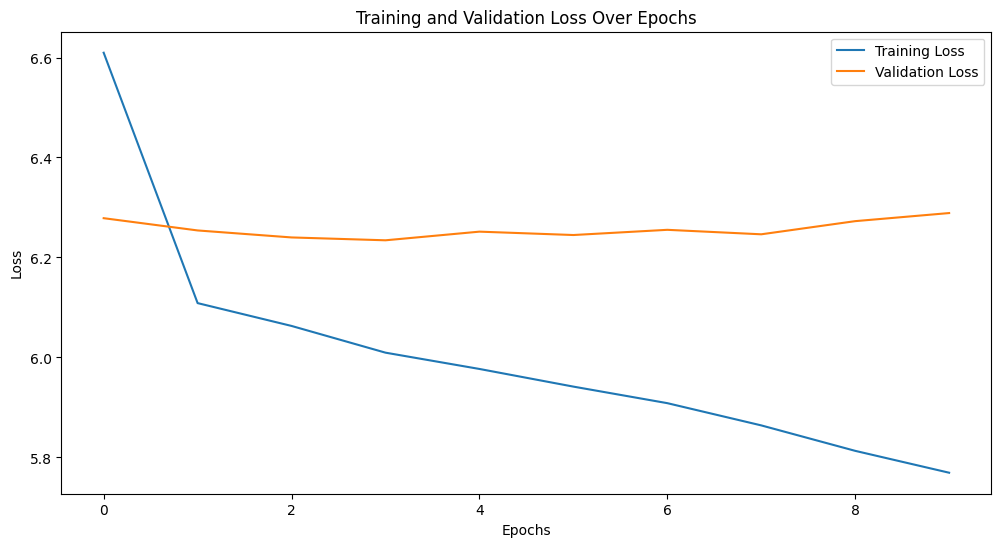

In [ ]:
import matplotlib.pyplot as plt

# Plotting loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Set X_val and y_val
X_val = padded_article_sequences
y_val = padded_summary_sequences

In [ ]:
def generate_summary(model, input_seq):
    prediction = model.predict(input_seq)

    # Check the shape of the prediction
    if len(prediction.shape) == 3:  # This means the model output is [batch_size, sequence_length, vocab_size]
        predicted_summary = ' '.join([tokenizer.index_word.get(i, '') for i in prediction[0].argmax(axis=1) if i != 0])
    elif len(prediction.shape) == 2:  # This means the model output is [batch_size, vocab_size]
        predicted_summary = ' '.join([tokenizer.index_word.get(i, '') for i in prediction.argmax(axis=1) if i != 0])
    else:
        raise ValueError("Unexpected prediction shape: {}".format(prediction.shape))

    return predicted_summary

In [ ]:
# Visualizing a few examples
for i in range(5):
    print(f"Article {i+1}:")
    print(decode_sequence(X_val[i]))
    print(f"Actual Summary {i+1}:")
    print(decode_sequence(y_val[i]))
    print(f"Predicted Summary {i+1}:")
    print(generate_summary(model, X_val[i].reshape(1, max_article_len)))
    print("-" * 50)


Article 1:
ever noticed plane seats appear getting smaller smaller increasing numbers people taking skies experts questioning packed planes putting passengers risk say shrinking space aeroplanes uncomfortable putting health safety danger squabbling arm rest shrinking space planes putting health safety danger week us consumer advisory group set department transportation said public hearing government happy set standards animals flying planes doesnt stipulate minimum amount space humans world animals rights space food humans said charlie leocha consumer representative committee time dot faa take stand humane treatment passengers could crowding planes lead serious issues fighting space overhead lockers crashing elbows seat back kicking tests conducted faa use planes 31 inch pitch standard airlines decreased many economy seats united airlines 30 inches room airlines offer little 28 inches cynthia corbertt human factors researcher federal aviation administration conducts tests quickly passe